# Subsetting GEDI L4A Footprints

This tutorial will demonstrate how to subset **Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD)**{cite}`dubayah2022` dataset to a study area of interest. GEDI L4A dataset is available for the period starting 2019-04-17 and covers latitudes of 52 North to 52 South. GEDI L4A data files are natively in HDF5 format, and each file represents one International Space Station (ISS) orbit. 

The [previous tutorial](gedi_l4a_search_download.ipynb) explains how to download GEDI L4A files for a study area of interest (bounding box or polygon) and a specific period. Once all the GEDI L4A files are downloaded, the global orbits of GEDI L4A can be clipped or subsetted to the study area of interest.

```{admonition} Learning Objectives
- Learn how to download GEDI L4A data by space (study area).
- Learn how to subset downloaded GEDI L4A dataset for an area of interest.
- Create a map of the GEDI shots showing AGBD
```

## Requirements
Additional prerequisites are provided [here](../docs/prerequisites). 

In [1]:
import h5py
import pandas as pd
import geopandas as gpd
import contextily as ctx
import h5py
import numpy as np
import earthaccess
from glob import glob
from os import path
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import orient

## 1. Polygonal Area of Interest

We will use the boundary of the [Great Smokey Mountain National Park (GRSM)](https://www.nps.gov/grsm/planyourvisit/maps.htm) to demonstrate the spatial subsetting process. The boundary file is in ESRI Shapefile format in the folder called `grsm` in the repository. Let's read the boundary file and print out its coordinate system.

In [2]:
poly = gpd.read_file('polygons/grsm/GRSM_BOUNDARY_POLYGON_fid17.shp').geometry
poly.crs

<Projected CRS: EPSG:26917>
Name: NAD83 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 84°W and 78°W - onshore and offshore. Canada - Nunavut; Ontario; Quebec. United States (USA) - Florida; Georgia; Kentucky; Maryland; Michigan; New York; North Carolina; Ohio; Pennsylvania; South Carolina; Tennessee; Virginia; West Virginia.
- bounds: (-84.0, 23.81, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

As we see above, the boundary file is in the UTM 17N projection. Now let's plot our study area over a base map. 

In [3]:
m = poly.explore(color='red',  fill=False)
m

## 2. Searching and Downloading GEDI L4A Files
We will search for all the GEDI L4A files with the orbits passing over the GRSM boundary using the `earthaccess` python module. Please refer to the [previous tutorial](gedi_l4a_search_download.ipynb) for more details.

In [4]:
# converting to WGS84 coordinate system
poly = poly.to_crs(epsg=4326)

# orienting coordinates clockwise
poly = poly.apply(orient, args=(1,))

# reducing number of vertices in the polygon
# CMR has 1000000 bytes limit
xy = poly.simplify(0.005).get_coordinates()

granules = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi="10.3334/ORNLDAAC/2056", # GEDI L4A DOI 
    polygon=list(zip(xy.x, xy.y))
)
print(f"Total granules found: {len(granules)}")

Total granules found: 187


The `granules` object contains metadata about the granules overlapping the GRSM area, including the bounding geometry, publication dates, data providers, etc. Now, let’s convert the above granule metadata from json-formatted to `geopandas` dataframe. Converting to `geopandas` dataframe will let us generate plots of the granule geometry. Let's plot the bounding geometries of the first few files.

In [5]:
def convert_umm_geometry(gpoly):
    """converts UMM geometry to multipolygons"""
    multipolygons = []
    for gl in gpoly:
        ltln = gl["Boundary"]["Points"]
        points = [(p["Longitude"], p["Latitude"]) for p in ltln]
        multipolygons.append(Polygon(points))
    return MultiPolygon(multipolygons)

def convert_list_gdf(datag):
    """converts List[] to geopandas dataframe"""
    # create pandas dataframe from json
    df = pd.json_normalize([vars(granule)['render_dict'] for granule in datag])
    # keep only last string of the column names
    df.columns=df.columns.str.split('.').str[-1]
    # convert polygons to multipolygonal geometry
    df["geometry"] = df["GPolygons"].apply(convert_umm_geometry)
    # return geopandas dataframe
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# only keep three columns
gdf = convert_list_gdf(granules)[['GranuleUR', 'size', 'geometry']]
# plotting the first three granule geometries
gdf[:10].explore(m=m, color='green',  fillcolor='green')

As we see in the map above, spatial bounds of GEDI L4A files extend beyond the area of interest (GRSM). 

## 3. Downloading the GEDI L4A files

We will use `earthaccess` python module to download all files. Please refer to the [previous tutorial](gedi_l4a_search_download.ipynb) for more details on downloading programmatically.

In [6]:
# authenticate using the EDL login
auth = earthaccess.login(strategy="netrc") 
if not auth.authenticated:
    # ask for EDL credentials and persist them in a .netrc file
    auth = earthaccess.login(strategy="interactive", persist=True)
# download files to full_orbits directory
downloaded_files = earthaccess.download(granules, local_path="full_orbits")

QUEUEING TASKS | :   0%|          | 0/374 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/374 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/374 [00:00<?, ?it/s]

## 4. Subsetting the GEDI L4A files

Once all the GEDI L4A files are downloaded, we can clip the full orbit files to retrieve the footprints that fall within the area of interest, i.e. GRSM boundary. We have downloaded all the files to a folder called `full_orbits` for this tutorial.

### 4a. Exploring the data structure
Let's first open one of the L4A file `GEDI04_A_2019133103100_O02354_03_T00724_02_002_02_V002.h5` we just downloaded and print the root-level variable group.

In [7]:
hf = h5py.File('full_orbits/GEDI04_A_2019133103100_O02354_03_T00724_02_002_02_V002.h5', 'r')
hf.keys()

<KeysViewHDF5 ['ANCILLARY', 'BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011', 'METADATA']>

All science variables are organized by eight beams of the GEDI. Please refer to the [GEDI L4A user guide](https://daac.ornl.gov/GEDI/guides/GEDI_L4A_AGB_Density_V2_1.html) and [GEDI L4A data dictionary](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density_V2_1/comp/GEDI_L4A_V2_Product_Data_Dictionary.pdf) for details on file organization. Let's look into one of the beam group `BEAM0110` and print all the science dataset (SDS) variables within the group. 

In [8]:
beam0110 = hf.get('BEAM0110')
beam0110.keys()

<KeysViewHDF5 ['agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_prediction', 'agbd_se', 'agbd_t', 'agbd_t_se', 'algorithm_run_flag', 'beam', 'channel', 'degrade_flag', 'delta_time', 'elev_lowestmode', 'geolocation', 'l2_quality_flag', 'l4_quality_flag', 'land_cover_data', 'lat_lowestmode', 'lon_lowestmode', 'master_frac', 'master_int', 'predict_stratum', 'predictor_limit_flag', 'response_limit_flag', 'selected_algorithm', 'selected_mode', 'selected_mode_flag', 'sensitivity', 'shot_number', 'solar_elevation', 'surface_flag', 'xvar']>

In the above list of variables, 2 science dataset (SDS)  are particulary useful for spatial subsetting: `lat_lowestmode` and `lon_lowestmode`, which represent ground location of each GEDI shot.

Let's plot all the beams in the map. 

In [9]:
lat_l = []
lon_l = []
beam_n = []
for var in list(hf.keys()):
    if var.startswith('BEAM'):
        beam = hf.get(var)
        lat = beam.get('lat_lowestmode')[:]
        lon = beam.get('lon_lowestmode')[:]
        lat_l.extend(lat.tolist()) # latitude
        lon_l.extend(lon.tolist()) # longitude
        n = lat.shape[0] # number of shots in the beam group
        beam_n.extend(np.repeat(str(var), n).tolist())
geo_arr = list(zip(beam_n,lat_l,lon_l))
l4adf = pd.DataFrame(geo_arr, columns=["beam", "lat_lowestmode", "lon_lowestmode"])
l4adf

beam  lat_lowestmode  lon_lowestmode
0        BEAM0000       51.820311     -136.039649
1        BEAM0000       51.820308     -136.038820
2        BEAM0000       51.820305     -136.037992
3        BEAM0000       51.820302     -136.037163
4        BEAM0000       51.820299     -136.036335
...           ...             ...             ...
1338244  BEAM1011       -0.243276      -52.168463
1338245  BEAM1011       -0.243705      -52.168161
1338246  BEAM1011       -0.244112      -52.167877
1338247  BEAM1011       -0.244559      -52.167559
1338248  BEAM1011       -0.244976      -52.167267

[1338249 rows x 3 columns]

The pandas dataframe `l4adf` contains beam names, latitude and longitude columns. This particular GEDI orbit recorded a total of 1,338,249 shots. Now we can convert `l4adf` to a geopandas dataframe `l4agdf` and clip the file by the boundary of the GRSM.

In [10]:
l4agdf = gpd.GeoDataFrame(l4adf, crs="EPSG:4326", 
                          geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
l4agdf_gsrm = l4agdf[l4agdf['geometry'].within(poly.geometry[0])]    
l4agdf_gsrm

beam  lat_lowestmode  lon_lowestmode                    geometry
77915    BEAM0000       35.695545      -83.583207  POINT (-83.58321 35.69555)
77916    BEAM0000       35.695196      -83.582730  POINT (-83.58273 35.69520)
77917    BEAM0000       35.694867      -83.582310  POINT (-83.58231 35.69487)
77918    BEAM0000       35.694515      -83.581828  POINT (-83.58183 35.69452)
77919    BEAM0000       35.694179      -83.581389  POINT (-83.58139 35.69418)
...           ...             ...             ...                         ...
1249364  BEAM1011       35.490195      -83.381600  POINT (-83.38160 35.49020)
1249365  BEAM1011       35.489855      -83.381146  POINT (-83.38115 35.48986)
1249366  BEAM1011       35.489514      -83.380690  POINT (-83.38069 35.48951)
1249367  BEAM1011       35.489177      -83.380240  POINT (-83.38024 35.48918)
1249368  BEAM1011       35.488839      -83.379788  POINT (-83.37979 35.48884)

[4503 rows x 4 columns]

The geopandas dataframe `l4agdf_gsrm` contains the shots (4,505 shots in total) that fall within the GSRM boundary. Now, let's plot these into a map.

In [11]:
l4agdf_gsrm.explore(column='beam', legend=True)

The above map shows the swath coverage of GEDI - a typical swath is ~4200m wide. GEDI instrument produces eight ground tracks plotted in the map with different colors. The GEDI shots (or footprints) are separated by ~60 m along the track and ~600 m across the track. For more detailed look on GEDI L4A data, refer to [this tutorial on exploring GEDI L4A](gedi_l4a_exploring_data.ipynb).

### 4b. Subsetting all downloaded files

In the Steps 2 and 3 above, we downloaded L4A files into the directory `full_orbits`. We will now loop over each of these files and create a clipped version of the files into a new directory `subsets`. 

In [12]:
indir = 'full_orbits'
outdir = 'subsets'

for infile in glob(path.join(indir, 'GEDI04_A*.h5')):
    name, ext = path.splitext(path.basename(infile))
    subfilename = "{name}_sub{ext}".format(name=name, ext=ext)
    outfile = path.join(outdir, path.basename(subfilename))
    
    # if the subset file doesn't already exists
    if not path.isfile(outfile):
        hf_in = h5py.File(infile, 'r')
        hf_out = h5py.File(outfile, 'w')
        
        # copy ANCILLARY and METADATA groups
        var1 = ["/ANCILLARY", "/METADATA"]
        for v in var1:
            hf_in.copy(hf_in[v],hf_out)
        
        # loop through BEAMXXXX groups
        for v in list(hf_in.keys()):
            if v.startswith('BEAM'):
                beam = hf_in[v]
                # find the shots that overlays the area of interest (GRSM)
                lat = beam['lat_lowestmode'][:]
                lon = beam['lon_lowestmode'][:]
                i = np.arange(0, len(lat), 1) # index
                geo_arr = list(zip(lat,lon, i))
                l4adf = pd.DataFrame(geo_arr, columns=["lat_lowestmode", "lon_lowestmode", "i"])
                l4agdf = gpd.GeoDataFrame(l4adf, crs="EPSG:4326", 
                                          geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
                l4agdf_gsrm = l4agdf[l4agdf['geometry'].within(poly.geometry[0])]  
                indices = l4agdf_gsrm.i
    
                # copy BEAMS to the output file
                for key, value in beam.items():
                    if isinstance(value, h5py.Group):
                        for key2, value2 in value.items():
                            group_path = value2.parent.name
                            group_id = hf_out.require_group(group_path)
                            dataset_path = group_path + '/' + key2
                            hf_out.create_dataset(dataset_path, data=value2[:][indices])
                            for attr in value2.attrs.keys():
                                hf_out[dataset_path].attrs[attr] = value2.attrs[attr]
                    else:
                        group_path = value.parent.name
                        group_id = hf_out.require_group(group_path)
                        dataset_path = group_path + '/' + key
                        hf_out.create_dataset(dataset_path, data=value[:][indices])
                        for attr in value.attrs.keys():
                            hf_out[dataset_path].attrs[attr] = value.attrs[attr]
    
        hf_in.close()
        hf_out.close()

Now, new the subset files are created in the `subsets` directory. We will use the subset files to create a map of above ground biomass density (the variable `agbd` inside `BEAMXXXX` groups) of the GRSM. 

In [13]:
lat_l = []
lon_l = []
agbd = []
outdir = 'subsets'
for subfile in glob(path.join(outdir, 'GEDI04_A*.h5')):
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            lat_l.extend(beam['lat_lowestmode'][:].tolist()) 
            lon_l.extend(beam['lon_lowestmode'][:].tolist()) 
            agbd.extend(beam['agbd'][:].tolist())
    hf_in.close()
geo_arr = list(zip(agbd,lat_l,lon_l))
df = pd.DataFrame(geo_arr, columns=["agbd", "lat_lowestmode", "lon_lowestmode"])
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_lowestmode, df.lat_lowestmode), crs="EPSG:4326")
gdf

agbd  lat_lowestmode  lon_lowestmode                    geometry
0      -9999.0       35.717420      -83.486708  POINT (-83.48671 35.71742)
1      -9999.0       35.717073      -83.486231  POINT (-83.48623 35.71707)
2      -9999.0       35.716726      -83.485766  POINT (-83.48577 35.71673)
3      -9999.0       35.716377      -83.485258  POINT (-83.48526 35.71638)
4      -9999.0       35.716030      -83.484793  POINT (-83.48479 35.71603)
...        ...             ...             ...                         ...
727205 -9999.0       35.447732      -83.705914  POINT (-83.70591 35.44773)
727206 -9999.0       35.447385      -83.705452  POINT (-83.70545 35.44739)
727207 -9999.0       35.447038      -83.704989  POINT (-83.70499 35.44704)
727208 -9999.0       35.446691      -83.704527  POINT (-83.70453 35.44669)
727209 -9999.0       35.446345      -83.704073  POINT (-83.70407 35.44634)

[727210 rows x 4 columns]

In the above table, we see there are some shots with fill value (-9999). We will exclude these shots in the map below. The following is a map of aboveground biomass density (Mg/ha) or `agbd`.

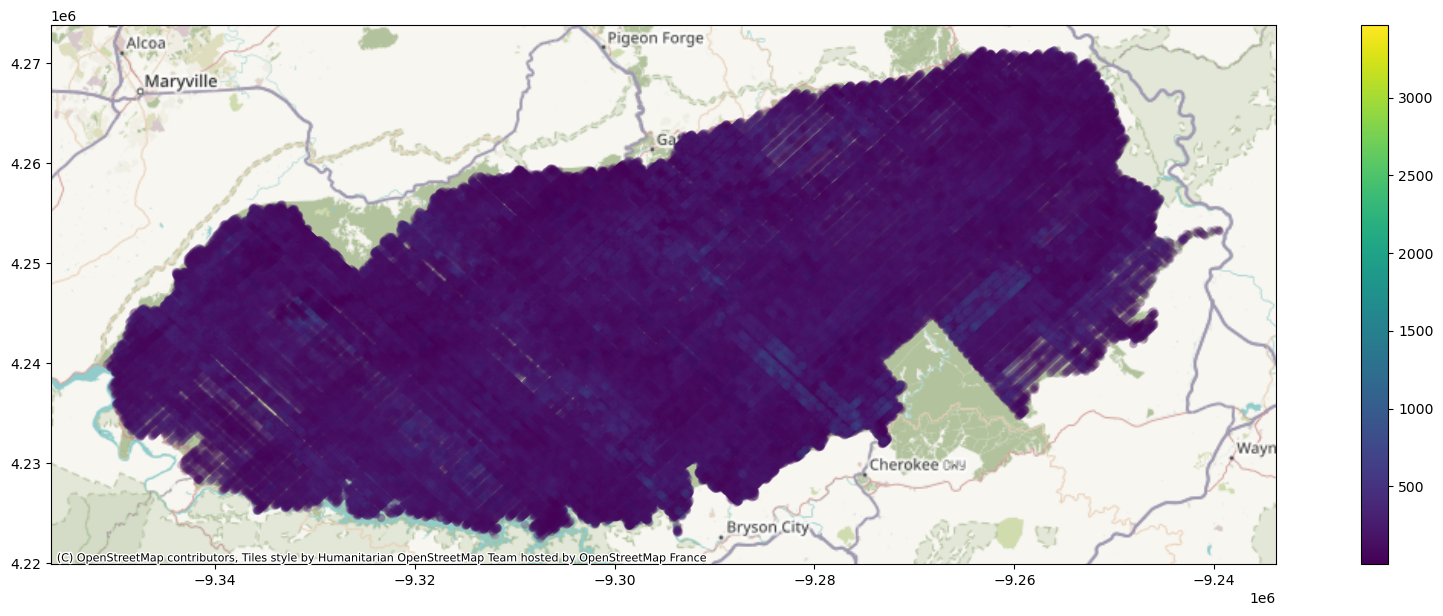

In [14]:
ax =gdf[gdf['agbd'] != -9999].to_crs(epsg=3857).plot(column='agbd', alpha=0.1, 
                                                     linewidth=0, legend=True, figsize=(22, 7))
ctx.add_basemap(ax)

### 4c. Saving the subsets to different formats
In the step above, we created a HDF5 formatted output, which is the native format of GEDI L4A datasets. The HDF5 files can be output to `geojson` or `csv` or `ESRI Shapefile` using the geopandas.

In [15]:
outdir = 'subsets'
subset_df = pd.DataFrame()
for subfile in glob(path.join(outdir, 'GEDI04_A*_sub.h5')):
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            col_names = []
            col_val = []
            beam = hf_in[v]
            # copy BEAMS 
            for key, value in beam.items():
                # looping through subgroups
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        if (key2 != "shot_number"):
                             # xvar variables have 2D
                            if (key2.startswith('xvar')):
                                for r in range(4):
                                    col_names.append(key2 + '_' + str(r+1))
                                    col_val.append(value2[:, r].tolist())
                            else:
                                col_names.append(key2)
                                col_val.append(value2[:].tolist())
                
                #looping through base group
                else:
                    # xvar variables have 2D
                    if (key.startswith('xvar')):
                        for r in range(4):
                            col_names.append(key + '_' + str(r+1))
                            col_val.append(value[:, r].tolist())
                    else:
                        col_names.append(key)
                        col_val.append(value[:].tolist())
            
            # create a pandas dataframe        
            beam_df = pd.DataFrame(map(list, zip(*col_val)), columns=col_names) 
            # Inserting BEAM names
            beam_df.insert(0, 'BEAM', np.repeat(str(v), len(beam_df.index)).tolist())
            
            # Appending to the subset_df dataframe
            if len(beam_df.index) > 0:
                subset_df = pd.concat([subset_df, beam_df])

    hf_in.close()

Now, all the variables are stored in a pandas dataframe `subset_df`. We can print the dataframe.

In [16]:
# Setting 'shot_number' as dataframe index. shot_number column is unique
subset_df = subset_df.set_index('shot_number') 
subset_df.head()

BEAM    agbd  agbd_pi_lower  agbd_pi_upper  agbd_a1  \
shot_number                                                                  
41710000300413617  BEAM0000 -9999.0        -9999.0        -9999.0  -9999.0   
41710000300413618  BEAM0000 -9999.0        -9999.0        -9999.0  -9999.0   
41710000300413619  BEAM0000 -9999.0        -9999.0        -9999.0  -9999.0   
41710000300413620  BEAM0000 -9999.0        -9999.0        -9999.0  -9999.0   
41710000300413621  BEAM0000 -9999.0        -9999.0        -9999.0  -9999.0   

                   agbd_a10  agbd_a2  agbd_a3  agbd_a4  agbd_a5  ...  \
shot_number                                                      ...   
41710000300413617   -9999.0  -9999.0  -9999.0  -9999.0  -9999.0  ...   
41710000300413618   -9999.0  -9999.0  -9999.0  -9999.0  -9999.0  ...   
41710000300413619   -9999.0  -9999.0  -9999.0  -9999.0  -9999.0  ...   
41710000300413620   -9999.0  -9999.0  -9999.0  -9999.0  -9999.0  ...   
41710000300413621   -9999.0  -9999.0  -9999.0  -9999.0  -9999.0  ...   

                   selected_algorithm  selected_mode  selected_mode_flag  \
shot_number                                                                
41710000300413617                   1              0                   0   
41710000300413618                   1              0                   0   
41710000300413619                   1              0                   0   
41710000300413620                   1              0                   0   
41710000300413621                   1              0                   0   

                   sensitivity  solar_elevation  surface_flag  xvar_1  xvar_2  \
shot_number                                                                     
41710000300413617     0.315933        21.527996             0 -9999.0 -9999.0   
41710000300413618    78.354553        21.528458             0 -9999.0 -9999.0   
41710000300413619     2.461639        21.528910             0 -9999.0 -9999.0   
41710000300413620    -1.414248        21.529398             0 -9999.0 -9999.0   
41710000300413621     8.056547        21.529850             0 -9999.0 -9999.0   

                   xvar_3  xvar_4  
shot_number                        
41710000300413617 -9999.0 -9999.0  
41710000300413618 -9999.0 -9999.0  
41710000300413619 -9999.0 -9999.0  
41710000300413620 -9999.0 -9999.0  
41710000300413621 -9999.0 -9999.0  

[5 rows x 204 columns]

The dataframe has 204 columns representing GEDI L4A variables. We can export it to a **CSV** file directly as:

In [17]:
subset_df.to_csv('subsets/grsm_subset.csv') # Export to CSV

If we want to save the file as one of the geospatial formats (such as GEOJSON, KML, ESRI Shapefile), we need to first convert the dataframe into a geopandas dataframe, and export to various formats.

In [ ]:
subset_gdf = gpd.GeoDataFrame(subset_df, crs="EPSG:4326", 
                              geometry=gpd.points_from_xy(subset_df.lon_lowestmode,
                                                          subset_df.lat_lowestmode))
# convert object types columns to strings. object types are not supported
for c in subset_gdf.columns:
    if subset_gdf[c].dtype == 'object':
        subset_gdf[c] = subset_gdf[c].astype(str)

# Export to GeoJSON
subset_gdf.to_file('subsets/grsm_subset.geojson', driver='GeoJSON')
# Export to ESRI Shapefile
subset_gdf.to_file('subsets/grsm_subset.shp')

## References
```{bibliography}
:style: plain
:filter: docname in docnames
```